# Morans I examples on integrated pancreas

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import gc

In [2]:
path_data='/om2/user/khrovati/data/'
path_adata=path_data+'datasets/d10_1101_2022_12_22_521557/'
path_integration=path_data+'cross_system_integration/eval/pancreas_conditions_MIA_HPAP2/'
path_save=path_integration+'integration_summary/moransi/'

In [3]:
# Load expression data (backed as dont need whole)
adata=sc.read(path_adata+'GSE211799_adata_atlas.h5ad',backed='r')

In [4]:
# Subset to beta cells from one example sample
adata=adata[
    (adata.obs.study_sample=='STZ_G1').values &
    (adata.obs.cell_type_integrated_v2_parsed=='beta').values
    ,:]
# Bring to memory the desired adata
adata=sc.AnnData(adata.raw.X, obs=adata.obs,var=adata.var)
gc.collect()

1663

In [5]:
adata.shape

(5795, 31706)

In [6]:
# Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [7]:
# Compute gene group scores
gene_groups=pd.read_excel(path_adata+'supplementary_tables/S8.xlsx',sheet_name='GPs').groupby('hc')
for hc,data in gene_groups:
    score_name='gene_score_cluster_'+str(hc)
    sc.tl.score_genes(adata, gene_list=data.EID, score_name=score_name, use_raw=False)

In [8]:
# Store embeddings (integrated an non-integrated)
embeds={}

In [9]:
# Compute NN graph on non-integrated
name='non-integrated'
embed=adata.copy()
del embed.obs
del embed.var
del embed.uns
del embed.obsm
del embed.varm
del embed.obsp
sc.pp.filter_genes(embed, min_cells=20)
sc.pp.highly_variable_genes(
     adata=embed, n_top_genes=2000, flavor='cell_ranger', subset=True)
n_pcs=15
sc.pp.scale(embed)
sc.pp.pca(embed, n_comps=n_pcs)
sc.pp.neighbors(embed, n_pcs=n_pcs)
embeds[name]=embed

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/

In [14]:
# Load top embeddings, subset to correct cels, and compute NN graph
for model,embed_dir in {model:dat['mid_run'] for model,dat in 
     pkl.load(open(path_integration+'integration_summary/top_settings.pkl','rb')).items()}.items():
    embed=sc.read(path_integration+'integration/'+embed_dir+'/embed_full.h5ad')
    embed=embed[adata.obs_names,:]
    sc.pp.neighbors(embed, use_rep='X')
    del embed.obs
    embeds[model]=embed

In [15]:
# Compute UMAP and moran's I for every embedding for the gene group scores
scores=[c for c in adata.obs.columns if 'gene_score' in c]
for embed in embeds.values():
    sc.tl.umap(embed)
    vals=adata.obs[scores]
    embed.obs[scores]=vals
    embed.uns['moransi']=dict(zip(
        scores,
        sc.metrics._morans_i._morans_i(
                    g=embed.obsp['connectivities'],
                    vals=vals.values.T)
         ))

In [16]:
# Save embeddings
pkl.dump(embeds,open(path_save+'pancreas_STZG1_healthyvar_topmodels.pkl','wb'))

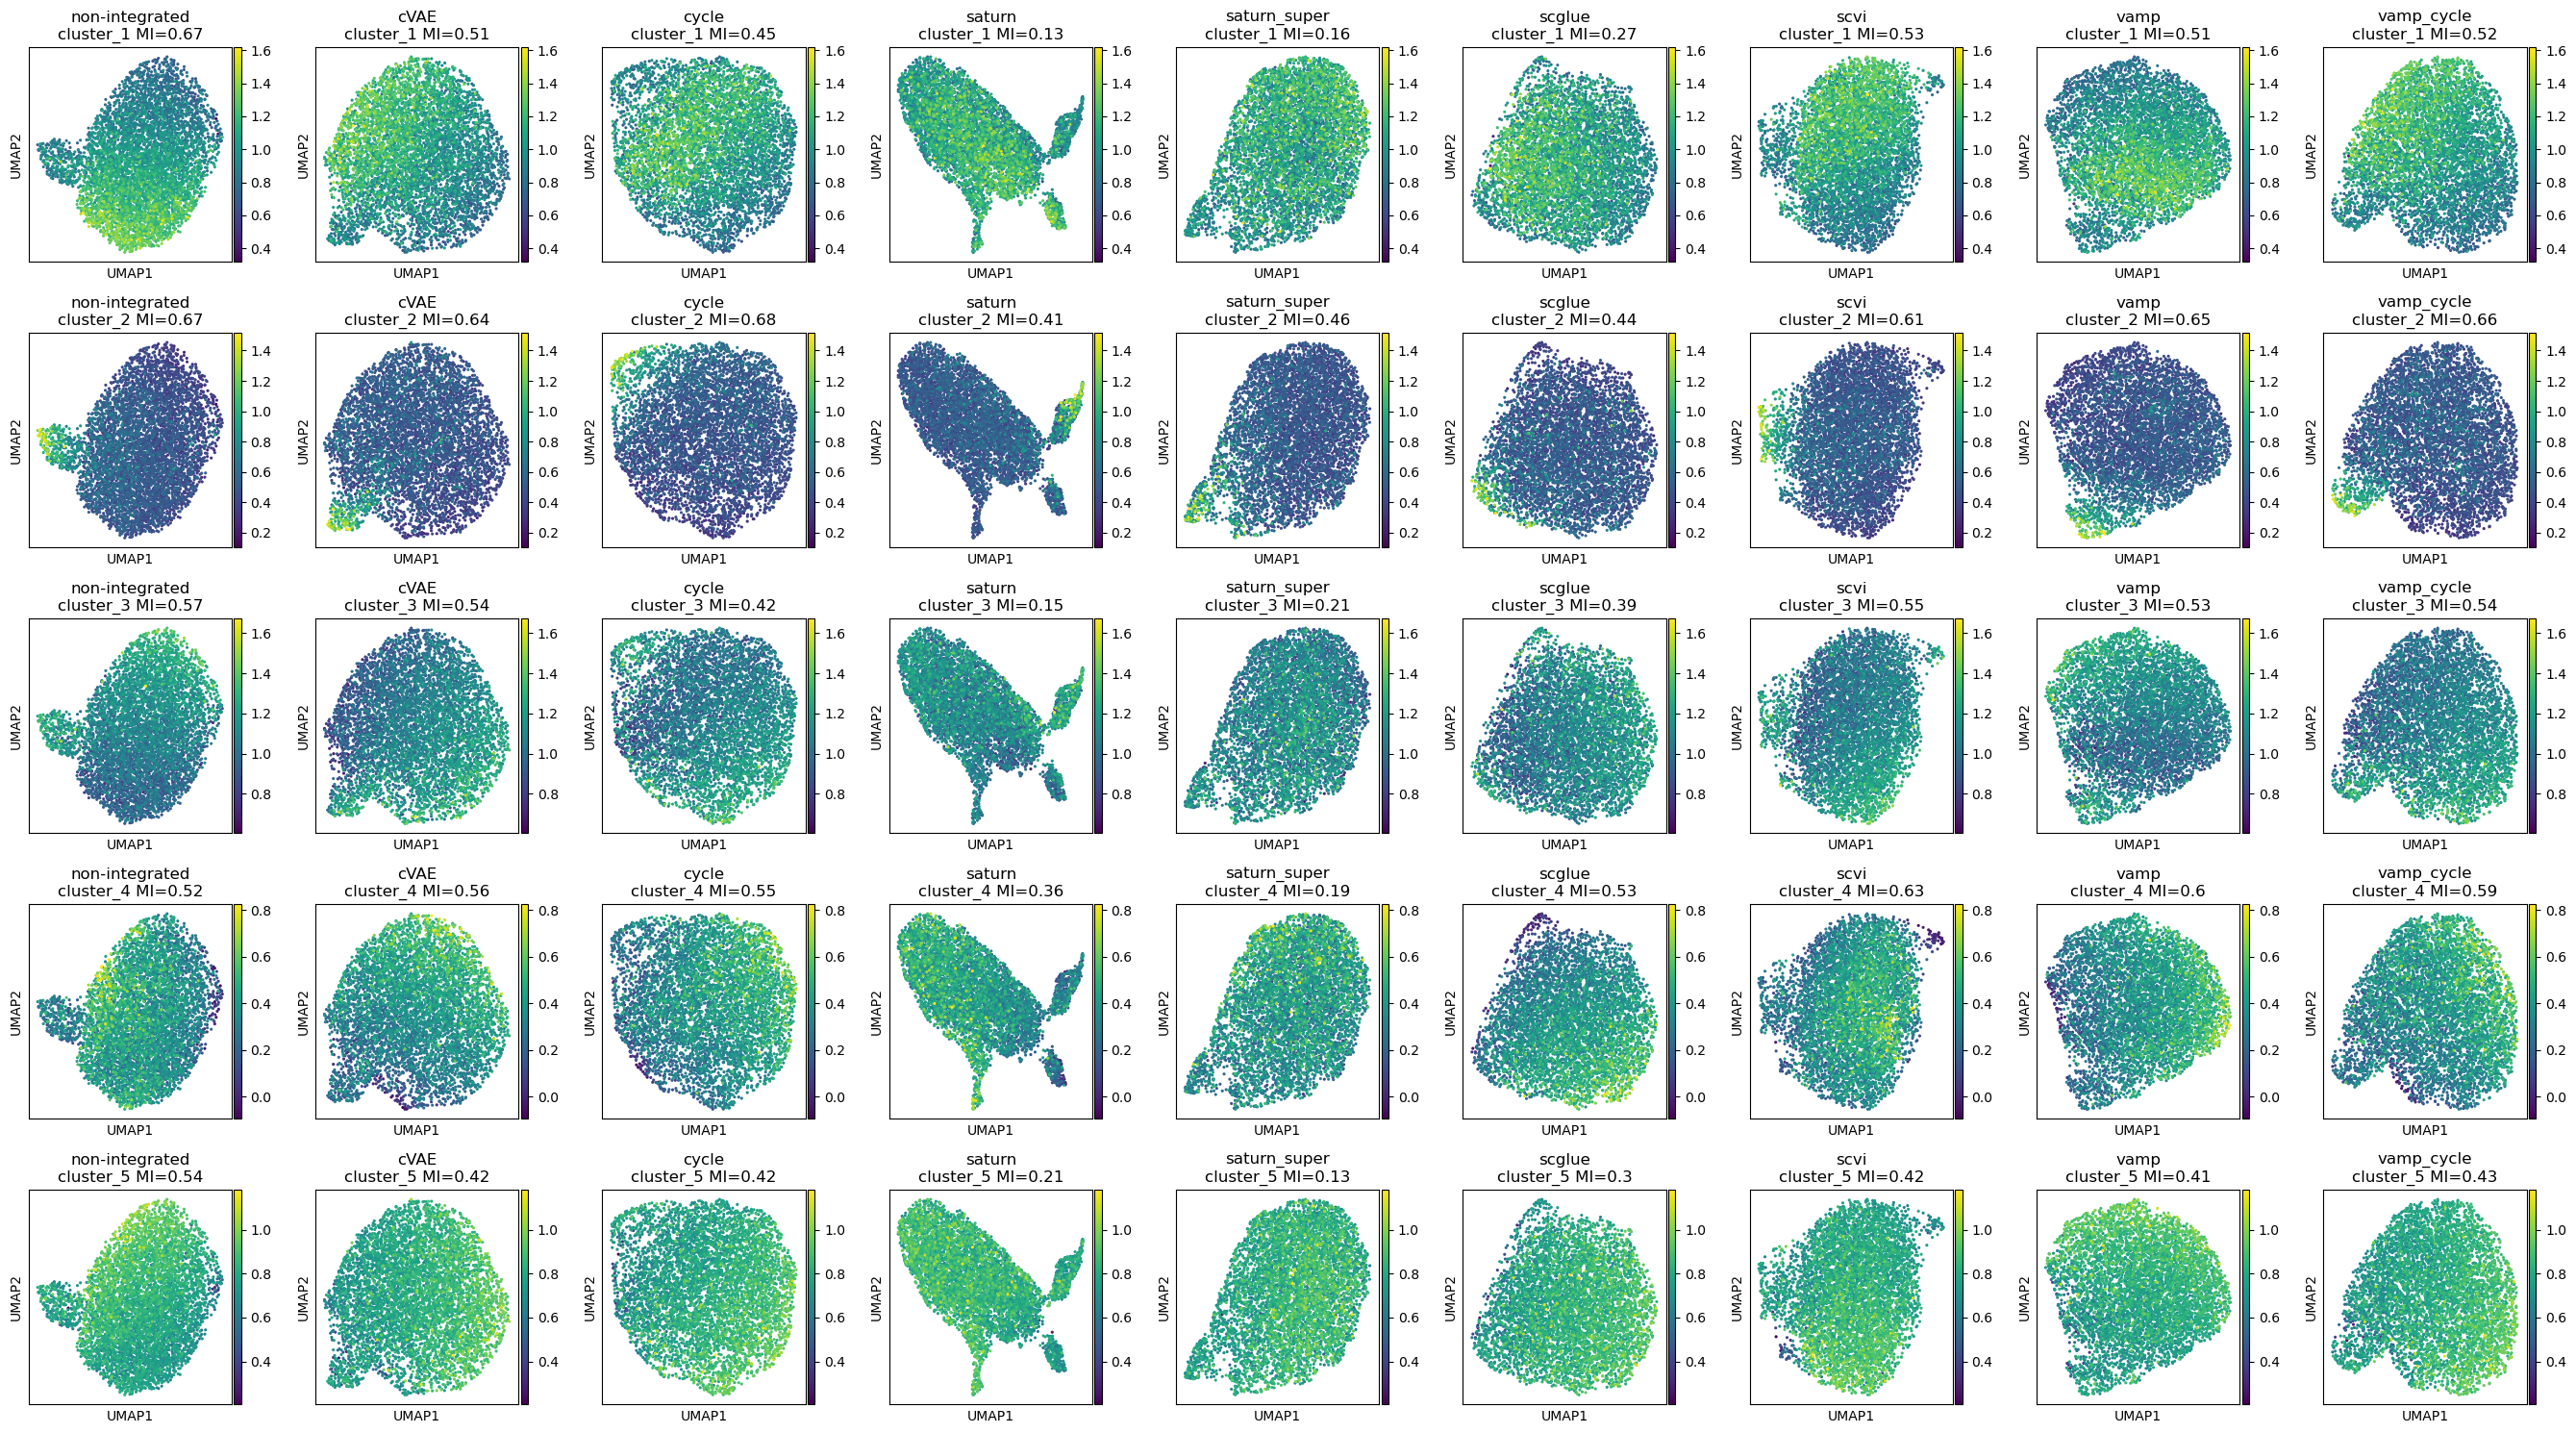

In [17]:
nrows=len(scores)
ncols=len(embeds)
fig,axs=plt.subplots(nrows,ncols,figsize=(3*ncols,3*nrows))
for col,(model,embed) in enumerate(embeds.items()):
    for row,score in enumerate(scores):
        ax=axs[row,col]
        mi=embed.uns['moransi'][score]
        sc.pl.umap(embed,color=score,ax=ax,show=False,
                   title=f"{model}\n{score.replace('gene_score_','')} MI={round(mi,2)}")
fig.tight_layout()